In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install plot_metric

In [ ]:
# !pip install "pandas<2.0.0"

In [ ]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
# from plot_metric.functions import BinaryClassification


warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500
from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
INV_URL = 'https://docs.google.com/spreadsheets/d/1N1SPW166_GFoCChWZY-KTg8-t40EaqiAAKRHdliY1Es/edit#gid=1652280687'
INV_SHEET = 'Consolidation 2023 & 2024'

INV_2024_URL = 'https://docs.google.com/spreadsheets/d/1N1SPW166_GFoCChWZY-KTg8-t40EaqiAAKRHdliY1Es/edit#gid=290771326'
INV_2024_SHEET = 'Consolidation 2024'

cols_list_underscore_cleaning = ['sku_name', 'product_name', 'package_type', 'brand', 'product_category', 'product_subcategory', 'warehouse_location', 'country',
            'country_of_origin', 'pack_label_language', 'product_restricted_countries', 'shelf_life_bucket']

inv_cols_list_to_change_dtypes = ['qty_of_cartons', 'units_per_cartons', 'retail_price_per_case_(local)', 'retail_price_per_case_(usd)', 'asking_price_per_case_(local)',
                              'asking_price_per_case_(usd)', 'total_retail_price_(local)', 'total_retail_price_(usd)', 'total_asking_price_(local)',
                              'total_asking_price_(usd)', 'pack_size_(number)', 'total_cbm', 'cbm_per_case', 'package_dimensions_per_package_type_(length)',
                              'package_dimensions_per_case_(width)', 'package_dimensions_per_case_(height)', 'net_weight_\nper_unit(kg)', 'net_weight_per_case_(kg)',
                              'gross_weight_per_case_(kg)', 'total_net_weight_(kg)', 'total_gross_weight_(kg)', 'cases_per_pallet', 'number_of_pallets', 'discount',
                              'shelf_remaining_days']

offer_cols_list_to_change_dtypes = ['offered_qty_(cartons)', 'units_per_carton', 'retail_price_unit_(usd)', 'retail_price_carton_(usd)', 'total_retail_price_(usd)',
                                    'asking_price_carton_(usd)', 'total_asking_price_(usd)', 'offer_price_unit_(usd)', 'total_offer_price_(usd)',
                                    'gross_weight_package_type_(kg)', 'total_gross_weight_(kg)', 'cbm_package_type', 'recovery_rate_(retail)', 'recovery_rate_(asking)',
                                    'discount_%']

cols_to_remove_from_train = ['bar_code_format_(ean_upc)', 'bar_code_number', 'manufactured_date', 'msds_file_(y_n)',
                             'minimum_accepted_price_per_carton_(local_currency)', 'minimum_accepted_price_per_carton_(usd)',
                             'total_minimum_asking_price_(local_currency)', 'total_minimum_price_(usd)', 'inventory_classification', 'latest_vs_archive',
                             'correct_vs_incorrect', 'date_of_offer', 'actual', 'offer_day_diff_updated_inv', 'sellability', 'product_category', 'product_subcategory']

get_RR_stats_of_these_cols = ['brand', 'product_category', 'product_subcategory', 'priority_order']

get_SR_stats_of_these_cols = ['seller', 'brand', 'priority_order', 'product_category', 'product_subcategory', 'seller_plus_priority', 'brand_plus_priority',
                              'product_category_plus_priority']

In [ ]:
def get_train_dumps():
  feat_to_RR_stats_mapping = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/feat_to_RR_stats_mapping.pkl")
  print('Recovery rates calculated on features - ', feat_to_RR_stats_mapping.keys(), '\n')
  feat_to_SR_stats_mapping = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/feat_to_SR_stats_mapping.pkl")
  print('Sell-thru rates calculated on features - ', feat_to_SR_stats_mapping.keys(), '\n')
  final_train_cols = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/final_train_cols.pkl")
  print('No. of train cols - ', len(final_train_cols), '\n')
  model = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/model.pkl")

  train_sku_number_list = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_sku_number_list.pkl")
  train_brand_list = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_brand_list.pkl")
  train_product_category_list = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_product_category_list.pkl")
  train_product_sub_category_list = joblib.load("/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/train_product_sub_category_list.pkl")
  FILTER_DATE =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sellability_model_train_filter_date.pkl')
  THRESHOLD =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/THRESHOLD.pkl')

  df_record =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/df_record.pkl')
  sku_number_mapping =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sku_number_mapping.pkl')
  brand_mapping =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/brand_mapping.pkl')
  product_category_mapping =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_category_mapping.pkl')
  product_subcategory_mapping =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_subcategory_mapping.pkl')
  currency_mapping =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/currency_mapping.pkl')
  brand_seller_depletion =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/brand_seller_depletion.pkl')
  product_category_seller_depletion =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_category_seller_depletion.pkl')
  product_subcategory_seller_depletion =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/product_subcategory_seller_depletion.pkl')
  sku_expiry_seller_depletion =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/sku_expiry_seller_depletion.pkl')
  record_attributes =  joblib.load('/content/drive/MyDrive/PSI_Modeling_Data/price_points_model/record_attributes.pkl')

  return feat_to_RR_stats_mapping, feat_to_SR_stats_mapping, final_train_cols, model, train_sku_number_list, train_brand_list, train_product_category_list,\
   train_product_sub_category_list, FILTER_DATE, THRESHOLD, df_record, sku_number_mapping, brand_mapping, product_category_mapping,\
   product_subcategory_mapping, currency_mapping, brand_seller_depletion, product_category_seller_depletion,\
          product_subcategory_seller_depletion, sku_expiry_seller_depletion, record_attributes

In [ ]:
feat_to_RR_stats_mapping, feat_to_SR_stats_mapping, final_train_cols, model, train_sku_number_list, train_brand_list, train_product_category_list,\
   train_product_sub_category_list, FILTER_DATE, THRESHOLD, df_record, sku_number_mapping, brand_mapping, product_category_mapping,\
   product_subcategory_mapping, currency_mapping, brand_seller_depletion, product_category_seller_depletion,\
   product_subcategory_seller_depletion, sku_expiry_seller_depletion, record_attributes = get_train_dumps()

Recovery rates calculated on features -  dict_keys(['brand', 'product_category', 'product_subcategory', 'priority_order']) 

Sell-thru rates calculated on features -  dict_keys(['seller', 'brand', 'priority_order', 'product_category', 'product_subcategory', 'seller_plus_priority', 'brand_plus_priority', 'product_category_plus_priority']) 

No. of train cols -  117 



In [ ]:
print('Filter date - ', FILTER_DATE, '\n', 'Threshold - ', THRESHOLD)

Filter date -  2024-10-21 00:00:00 
 Threshold -  0.6


In [ ]:
def read_input_data(INV_URL, INV_SHEET):
  spr = gc.open_by_url(INV_URL)
  wks = spr.worksheet(INV_SHEET)
  rows = wks.get_all_values()
  df_inv = pd.DataFrame.from_records(rows)
  df_inv = df_inv.rename(columns=df_inv.iloc[3]).iloc[4:].reset_index(drop = True)
  return df_inv

In [ ]:
df_inv = read_input_data(INV_URL, INV_SHEET)
df_inv_2024 = read_input_data(INV_2024_URL, INV_2024_SHEET)

In [ ]:
df_inv = df_inv.loc[:, [i for i in df_inv.columns if i != '']]
df_inv = df_inv.rename(columns = {' Retail Price per Case (Local) ' : 'Retail Price per Case (Local)', ' Retail Price per Case (USD) ' : 'Retail Price per Case (USD)',
                         ' Asking Price per Case (Local) ' : 'Asking Price per Case (Local)', ' Asking Price per Case (USD) ' : 'Asking Price per Case (USD)'})
df_inv = pd.concat([df_inv, df_inv_2024], ignore_index = True)

In [ ]:
def column_rename(df, column_list):
  for i in column_list:
    new_col = i.lower().replace(' ', '_').replace('-', '_').replace('/', '_')
    if new_col != '':
      if new_col[0] == '_':
        new_col = new_col[1:]
      if new_col[-1] == '_':
        new_col = new_col[:-1]
    df.rename(columns = {i : new_col}, inplace = True)
  return df

In [ ]:
def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'pack_label_language', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month',
              'product_category', 'product_subcategory']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

In [ ]:
def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

In [ ]:
def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

In [ ]:
def get_priority_for_offers(x):
  return x.split('_')[0][1:3]

In [ ]:
df_inv = column_rename(df_inv, df_inv.columns)
df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)

if '' in df_inv.columns:
  df_inv = df_inv.drop('', axis = 1)

df_inv = cleaning_underscores_inv_data(df_inv, cols_list_underscore_cleaning)

In [ ]:
df_inv['priority_order'] = df_inv.shelf_life_bucket.apply(get_priority_for_offers)

In [ ]:
df_inv['store_name'] = df_inv['store_name'].str.replace('_', '')
df_inv = df_inv.rename(columns = {'earliest_expiry_date' : 'expiry_date', 'store_name' : 'seller'})

In [ ]:
def do_datatype_conversion(df_inv):
  df_inv['total_units'] = df_inv['total_units'].str.replace(',', '')
  df_inv = df_inv[df_inv['total_units'] != '']
  df_inv['total_units'] = df_inv['total_units'].astype(float)
  df_inv = df_inv[~df_inv['expiry_date'].isin(['-', 'P1', 'P2', 'P3', 'MTO'])]
  df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'], format = "%d-%b-%Y")
  df_inv = df_inv[~df_inv.updated_on.isin(['20- Dec- 2023'])]
  df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])
  return df_inv

In [ ]:
df_inv = do_datatype_conversion(df_inv)

In [ ]:
filter_date_for_test = pd.to_datetime(FILTER_DATE)
df_inv = df_inv[df_inv.updated_on > filter_date_for_test]
print(filter_date_for_test)

2024-10-21 00:00:00


In [ ]:
df_inv = df_inv.drop_duplicates()

In [ ]:
def inv_status(df_inv):
  print('Inv shape - ', df_inv.shape)

In [ ]:
inv_status(df_inv)

Inv shape -  (2389, 61)


In [ ]:
df_inv.seller.unique()

array(['ulth', 'ulsg', 'ulmy', 'ulid', 'lomy', 'loth'], dtype=object)

In [ ]:
# Since inferencing, not removing rows - catboost will itself impute what's necessary

def change_dtype(df, feat):
  # '', '-'
  df[feat] = df[feat].str.replace(' ', '').str.replace(',', '').str.replace('$', '').str.replace('%', '').str.replace('G', '').str.replace('#VALUE!', '')
  df = df[~df[feat].isin(['#DIV/0!', '$0.1000', '$0.67', '#N/A', 'Tube50g+Bottle50ml+Sachet5ml', 'Tube100mlSachet2x6mlBottle40ml',
                          'Bottle72mlTube48mlT12mlB40ml', '6x6x1mL', '22ML5.5ML', 'Sachet20gSachet20ml', 'Sachet20g+20ml', 'Sachet30g;30ml', 'Sachet-Sachet', '10x28g',
                           'Sachet20grSachet20ml', 'Tube100mlSachet2x6mlBotol40ml', '30X1.85', 'Tube50+Bottle50ml+Sachet5ml', '28g'])]
  df[feat] = df[feat].replace('', np.nan).replace('-', np.nan)
  df[feat] = df[feat].astype(float)
  return df

In [ ]:
for feat in inv_cols_list_to_change_dtypes:
  df_inv = change_dtype(df_inv, feat)

In [ ]:
inv_status(df_inv)

Inv shape -  (2389, 61)


In [ ]:
df_inv.seller.unique()

array(['ulth', 'ulsg', 'ulmy', 'ulid', 'lomy', 'loth'], dtype=object)

In [ ]:
df_inv = pd.merge(df_inv, sku_expiry_seller_depletion, 'left', on = ['sku_number', 'expiry_date', 'seller'])
df_inv = pd.merge(df_inv, brand_seller_depletion, 'left', on = ['brand', 'seller'])
df_inv = pd.merge(df_inv, product_category_seller_depletion, 'left', on = ['product_category', 'seller'])
df_inv = pd.merge(df_inv, product_subcategory_seller_depletion, 'left', on = ['product_subcategory', 'seller'])

In [ ]:
df_inv['sku_expiry_seller_depletion'].isnull().sum() / df_inv.shape[0]

0.552113855169527

In [ ]:
feat_to_RR_stats_mapping.keys()

dict_keys(['brand', 'product_category', 'product_subcategory', 'priority_order'])

In [ ]:
for feat in get_RR_stats_of_these_cols:
  df_inv = pd.merge(df_inv, feat_to_RR_stats_mapping[feat], 'left', on = feat)

In [ ]:
def get_combination_feats(df):
  df['sku_plus_priority'] = df.sku_number.astype('str') + '_' + df.priority_order.astype('str')
  df['seller_plus_priority'] = df.seller.astype('str') + '_' + df.priority_order.astype('str')
  df['brand_plus_priority'] = df['brand'].astype('str') + '_' + df.priority_order.astype('str')
  df['product_category_plus_priority'] = df['product_category'].astype('str') + '_' + df.priority_order.astype('str')
  return df

In [ ]:
df_inv = get_combination_feats(df_inv)

In [ ]:
for feat in get_SR_stats_of_these_cols:
  df_inv = pd.merge(df_inv, feat_to_SR_stats_mapping[feat], 'left', on = feat)

# Predict Probs

In [ ]:
df_inv['retail_price_per_unit_usd'] = df_inv['total_retail_price_(usd)'] / df_inv['total_units']
df_inv['asking_price_per_unit_usd'] = df_inv['total_asking_price_(usd)'] / df_inv['total_units']

In [ ]:
def get_discounted_price(retail_price):
  test_prices = []
  for i in range(1,10):
    test_prices.append(retail_price * i*0.1)
  return test_prices

In [ ]:
df_inv['offer_price_unit_(usd)'] = df_inv['retail_price_per_unit_usd'].apply(get_discounted_price)

In [ ]:
def add_asking(df):
  x = [df['asking_price_per_unit_usd']] + df['offer_price_unit_(usd)']
  return x

df_inv['offer_price_unit_(usd)'] = df_inv.apply(add_asking, axis = 1)

In [ ]:
df_inv = df_inv.explode('offer_price_unit_(usd)')
df_inv = df_inv.reset_index(drop = True)

In [ ]:
df_inv.head(2)

,updated_on,seller,sku_number,expiry_date,sku_name,product_name,package_type,qty_of_cartons,units_per_cartons,total_units,currency,retail_price_per_case_(local),retail_price_per_case_(usd),asking_price_per_case_(local),asking_price_per_case_(usd),total_retail_price_(local),total_retail_price_(usd),total_asking_price_(local),total_asking_price_(usd),pack_size_(number),pack_size_(unit),bar_code_number,bar_code_format_(ean_upc),brand,product_category,product_subcategory,total_cbm,cbm_per_case,package_dimensions_per_package_type_(length),package_dimensions_per_case_(width),package_dimensions_per_case_(height),unit_(case),net_weight_\nper_unit(kg),net_weight_per_case_(kg),gross_weight_per_case_(kg),total_net_weight_(kg),total_gross_weight_(kg),cases_per_pallet,number_of_pallets,warehouse_location,country,manufactured_date,country_of_origin,pack_label_language,dangerous_goods\n(y_n),msds_file_(y_n),product_restricted_countries,minimum_accepted_price_per_carton_(local_currency),minimum_accepted_price_per_carton_(usd),total_minimum_asking_price_(local_currency),total_minimum_price_(usd),discount,shelf_remaining_days,shelf_life_bucket,inventory_classification,relavant_(r)_ir_relavant(ir),latest_vs_archive,correct_vs_incorrect,old_product_category,old_product_subcategory,priority_order,sku_expiry_seller_depletion,brand_seller_depletion,product_category_seller_depletion,product_subcategory_seller_depletion,min_RR_brand,max_RR_brand,median_RR_brand,std_RR_brand,mean_RR_brand,min_RR_product_category,max_RR_product_category,median_RR_product_category,std_RR_product_category,mean_RR_product_category,min_RR_product_subcategory,max_RR_product_subcategory,median_RR_product_subcategory,std_RR_product_subcategory,mean_RR_product_subcategory,min_RR_priority_order,max_RR_priority_order,median_RR_priority_order,std_RR_priority_order,mean_RR_priority_order,sku_plus_priority,seller_plus_priority,brand_plus_priority,product_category_plus_priority,min_SR_seller,max_SR_seller,median_SR_seller,std_SR_seller,mean_SR_seller,min_SR_brand,max_SR_brand,median_SR_brand,std_SR_brand,mean_SR_brand,min_SR_priority_order,max_SR_priority_order,median_SR_priority_order,std_SR_priority_order,mean_SR_priority_order,min_SR_product_category,max_SR_product_category,median_SR_product_category,std_SR_product_category,mean_SR_product_category,min_SR_product_subcategory,max_SR_product_subcategory,median_SR_product_subcategory,std_SR_product_subcategory,mean_SR_product_subcategory,min_SR_seller_plus_priority,max_SR_seller_plus_priority,median_SR_seller_plus_priority,std_SR_seller_plus_priority,mean_SR_seller_plus_priority,min_SR_brand_plus_priority,max_SR_brand_plus_priority,median_SR_brand_plus_priority,std_SR_brand_plus_priority,mean_SR_brand_plus_priority,min_SR_product_category_plus_priority,max_SR_product_category_plus_priority,median_SR_product_category_plus_priority,std_SR_product_category_plus_priority,mean_SR_product_category_plus_priority,retail_price_per_unit_usd,asking_price_per_unit_usd,offer_price_unit_(usd)
0,2024-10-29,ulth,62697057,2026-10-18,vaseline_pure_jelly_skin_le_12x3x50ml,vaseline_pure_jelly_skin_le_12x3x50ml,carton,2697.0,36.0,97092.0,thb,2844.0,82.25,853.2,24.68,7670268.0,221841.13,2301080.4,66552.34,50.0,ML,8851932466332,EAN,vaseline,skin_care,body_lotions_&_creams,0.24,0.01,235.0,193.0,144.0,MM,0.06,2.2,1.62,5933.4,4369.14,175.0,15.41,th_warehouse,thailand,-,-,-,-,-,-,-,-,-,-,70.0,704.0,(p3)_>1_year,-,,,,NaN,NaN,p3,NaN,10661.2,10661.2,7376.666667,0.023909,0.643072,0.317388,0.194579,0.276902,0.008414,0.652365,0.186095,0.115648,0.163969,0.009617,0.643072,0.178361,0.127682,0.158042,0.006703,0.93952,0.177415,0.121181,0.171,62697057_p3,ulth_p3,vaseline_p3,skin_care_p3,0.0,1.0,0.0,0.265137,0.093967,0.0,1.0,0.0,0.150552,0.063517,0.0,1.0,0.0,0.214107,0.120393,0.0,1.0,0.0,0.249931,0.078448,0.0,1.0,0.0,0.24875,0.082667,0.0,1.0,0.0,0.250018,0.113721,0.0,1.0,0.0,0.154662,0.183475,0.0,1.0,0.0,0.266902,0.114272,2.284855,0.685456,0.685456
1,2024-10-29,ulth,626970

In [ ]:
probs = model.predict_proba(df_inv[final_train_cols])
df_inv['probs'] = probs[:,1]

### Threshold

In [ ]:
print(THRESHOLD)

0.6


# change below date as per the month

In [ ]:
df_inv = df_inv[df_inv.updated_on >= '2024-11-01']

In [ ]:
df_inv['probs'] = df_inv['probs'] * 100
df_inv = df_inv.reset_index(drop = True)
df_inv.shape

(23820, 133)

## keeping only the rows with asking == offer. Later remove it

In [ ]:
df_inv = df_inv[df_inv['asking_price_per_unit_usd'] == df_inv['offer_price_unit_(usd)']]
df_inv.shape

(2499, 133)

In [ ]:
df_inv.seller.unique()

array(['ulmy', 'ulsg', 'ulid', 'ulth', 'lomy', 'loth'], dtype=object)

In [ ]:
# cols_to_have_price_points = ['updated_on', 'seller', 'sku_number', 'expiry_date', 'sku_name', 'retail_price_per_unit_usd',
#                              'asking_price_per_unit_usd', 'offer_price_unit_(usd)', 'probs']
# df_inv_price_points = df_inv[cols_to_have_price_points]

In [ ]:
# df_inv_price_points.head(10)

# Dumping results

In [ ]:
MONTH = 'November'
SELLER = 'loth'

df_inv_seller_wise = df_inv[df_inv['seller'] == SELLER]
print(df_inv_seller_wise.shape)

(123, 133)


In [ ]:
df_inv_seller_wise = df_inv_seller_wise.sort_values(by = 'probs', ascending = False)

In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'sellability_at_multiple_price_points.xlsx'
print(write_path)

df_inv_seller_wise.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_sellability_at_multiple_price_points.xlsx


In [ ]:
df_inv_seller_wise['total_retail_price_(usd)'] = df_inv_seller_wise['total_retail_price_(usd)'].astype('float')

In [ ]:
df_inv_seller_wise['probs_x_total_retail_price_(usd)'] = df_inv_seller_wise['total_retail_price_(usd)'] * df_inv_seller_wise['probs']
temp = df_inv_seller_wise.groupby(['product_category', 'brand']).agg({'probs_x_total_retail_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum', \
                                                                      'total_units' : 'sum'}).reset_index()
temp['weighted_probs'] = temp['probs_x_total_retail_price_(usd)'] / temp['total_retail_price_(usd)']
temp = temp.sort_values(by = ['total_units'], ascending = False)
# temp = temp[temp.total_units >= np.percentile(temp.total_units, 70)]
temp = temp[['product_category', 'brand', 'weighted_probs']]

In [ ]:
temp

,product_category,brand,weighted_probs
3,makeup,maybelline,89.866073
4,skin_care,garnier,83.579892
2,makeup,l'oreal_paris,34.002759
5,skin_care,l'oreal_paris,77.886081
1,hair_care,l'oreal_paris,88.072774
0,hair_care,garnier,25.542493


# Full inventory level score

In [ ]:
FULL_INV_SCORE = df_inv_seller_wise['probs_x_total_retail_price_(usd)'].sum() / df_inv_seller_wise['total_retail_price_(usd)'].sum()
print(FULL_INV_SCORE)

61.207053808156004


# Brand level score

In [ ]:
x = df_inv_seller_wise.groupby(['brand']).agg({'probs_x_total_retail_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum', \
                                                                      'total_units' : 'sum'}).reset_index()
x['brand_lvl_score'] = x['probs_x_total_retail_price_(usd)'] / x['total_retail_price_(usd)']
BRAND_LVL_SCORE = x.brand_lvl_score.sum() / x.brand.nunique()
print(BRAND_LVL_SCORE)

72.48149989243389


In [ ]:
x = x[['brand', 'brand_lvl_score']].sort_values(by = 'brand_lvl_score', ascending = False)
x

,brand,brand_lvl_score
2,maybelline,89.866073
0,garnier,83.572090
1,l'oreal_paris,44.006337


In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'top_brands.xlsx'
print(write_path)

x.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_top_brands.xlsx


# Product category level score

In [ ]:
x = df_inv_seller_wise.groupby(['product_category']).agg({'probs_x_total_retail_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum', \
                                                                      'total_units' : 'sum'}).reset_index()
x['cat_lvl_score'] = x['probs_x_total_retail_price_(usd)'] / x['total_retail_price_(usd)']
CAT_LVL_SCORE = x.cat_lvl_score.sum() / x.product_category.nunique()
print(CAT_LVL_SCORE)

74.64389436023579


In [ ]:
x = x[['product_category', 'cat_lvl_score']].sort_values(by = 'cat_lvl_score', ascending = False)
x

,product_category,cat_lvl_score
0,hair_care,88.060335
2,skin_care,82.934918
1,makeup,52.936430


In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'top_cats.xlsx'
print(write_path)

x.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_top_cats.xlsx


In [ ]:
x = df_inv_seller_wise.groupby(['product_subcategory']).agg({'probs_x_total_retail_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum', \
                                                                      'total_units' : 'sum'}).reset_index()
x['subcat_lvl_score'] = x['probs_x_total_retail_price_(usd)'] / x['total_retail_price_(usd)']
SUBCAT_LVL_SCORE = x.subcat_lvl_score.sum() / x.product_subcategory.nunique()
print(SUBCAT_LVL_SCORE)

81.77939268127797


In [ ]:
x = x[['product_subcategory', 'subcat_lvl_score']].sort_values(by = 'subcat_lvl_score', ascending = False)
x

,product_subcategory,subcat_lvl_score
6,hair_color,95.183725
7,lip_makeup,93.651963
11,styling,90.908077
1,cleansers_&_toners,88.280644
10,shampoo,87.159621
0,body_lotions_&_creams,86.698347
5,hair_care_-_others,84.885509
3,eye_makeup,82.965653
9,serums_&_treatments,81.191399
12,sunscreen_&_spf_products,78.829034


In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'top_subcats.xlsx'
print(write_path)

x.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_top_subcats.xlsx


In [ ]:
data = [['Full Inventory Score', FULL_INV_SCORE], ['Brand Level Score', BRAND_LVL_SCORE], ['Category Level Score', CAT_LVL_SCORE], ['Subcategory Level Score', SUBCAT_LVL_SCORE]]
high_level_inventory_scores_df = pd.DataFrame(data, columns=['Score Type', 'Score'])

In [ ]:
high_level_inventory_scores_df

,Score Type,Score
0,Full Inventory Score,61.207054
1,Brand Level Score,72.481500
2,Category Level Score,74.643894
3,Subcategory Level Score,81.779393


In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'high_level_inventory_scores.xlsx'
print(write_path)

high_level_inventory_scores_df.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_high_level_inventory_scores.xlsx


In [ ]:
temp_pivot = temp.pivot(index="product_category", columns="brand", values="weighted_probs").fillna(0)

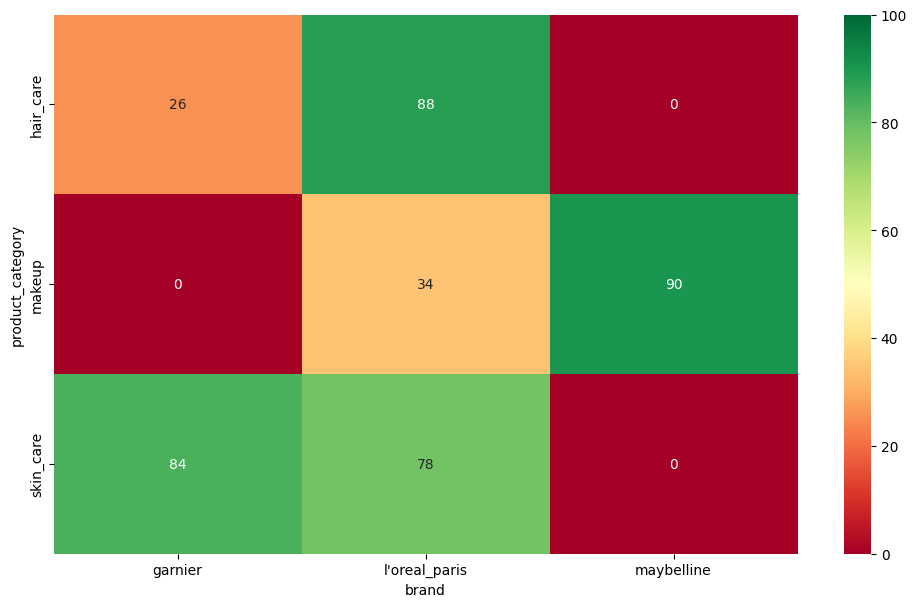

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,7)
heatmap = sns.heatmap(temp_pivot, annot = True, cmap = 'RdYlGn', vmin=0, vmax=100)

In [ ]:
fig = heatmap.get_figure()
print('/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/heatmap.png')
fig.savefig('/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/heatmap.png')

/content/drive/MyDrive/November_Results/November_LOTH_scores/heatmap.png


In [ ]:
temp = df_inv_seller_wise.groupby(['sku_number']).agg({'probs_x_total_retail_price_(usd)' : 'sum', 'total_retail_price_(usd)' : 'sum', 'total_units' : 'sum'}).reset_index()
temp['weighted_probs'] = temp['probs_x_total_retail_price_(usd)'] / temp['total_retail_price_(usd)']
temp = temp.sort_values(by = 'weighted_probs', ascending = False)
temp = temp.rename(columns = {'weighted_probs' : 'sellability_score'})

top_10_skus = temp[['sku_number', 'sellability_score', 'total_units']][:10]
bottom_10_skus = temp[['sku_number', 'sellability_score', 'total_units']][-10:]

In [ ]:
top_10_skus

,sku_number,sellability_score,total_units
108,ZTH02635,99.134858,27.0
31,G4247400,98.003756,191.0
94,YTH02767,97.787422,18910.0
105,ZTH02631,97.767579,516.0
103,ZTH02629,97.730442,298.0
32,G4247500,97.691015,319.0
85,XTH01565,97.568688,3447.0
33,G4247600,97.566721,1295.0
35,G4252800,97.063775,1603.0
104,ZTH02630,97.020309,126.0


In [ ]:
bottom_10_skus

,sku_number,sellability_score,total_units
81,XTH01522,25.542493,19.0
3,AA187100,24.063694,753.0
8,AA187900,23.317947,5360.0
42,G4431300,21.396625,18.0
15,G3457400,17.954689,18.0
54,K4997200,15.972660,16.0
5,AA187200,15.677338,10559.0
2,AA186900,12.903645,4323.0
41,G4431200,10.643845,17.0
55,XTH00516,8.774108,12.0


In [ ]:
write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'top_10_skus.xlsx'
print(write_path)

top_10_skus.to_excel(write_path)

write_path = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_' + SELLER.upper() + '_scores/' + MONTH + '_' + SELLER.upper() + '_' + 'bottom_10_skus.xlsx'
print(write_path)

bottom_10_skus.to_excel(write_path)

/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_top_10_skus.xlsx
/content/drive/MyDrive/November_Results/November_LOTH_scores/November_LOTH_bottom_10_skus.xlsx
